# Image Provider 

In [13]:
from datagenerator import TightFaceProvider
from helper import show_images, cropper, glob_all_files,paths2numpy

In [2]:
fg_folder = './images/face_tight_images/'
bg_folder = './images/block_full_images/'
tfp = TightFaceProvider(fg_folder, bg_folder, batch_size=128)

Max Height : 54 	 Min Height : 15
Max Width : 39 	 Min Width : 13
Max W/H Ratio : 1.0666666666666667 	 Min Ratio : 0.5862068965517241


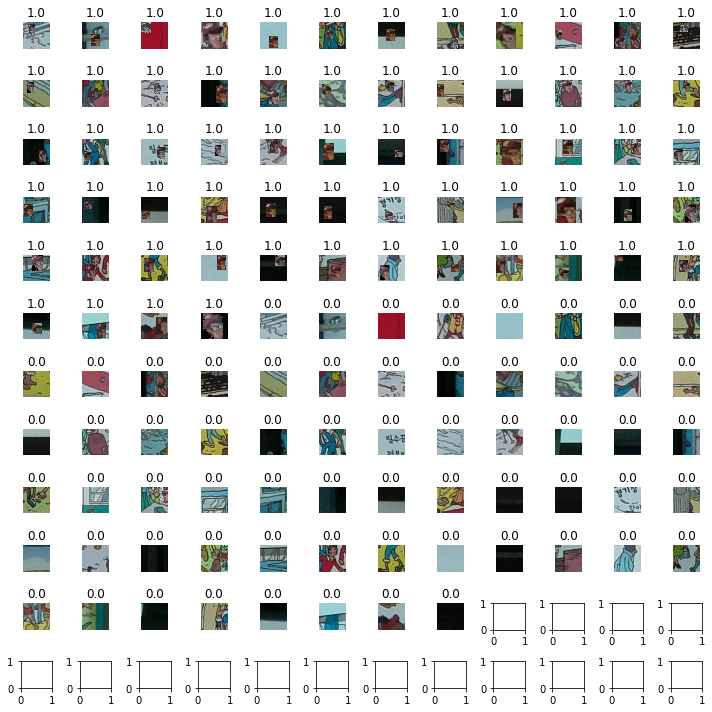

In [3]:
# 0번째 index의 batch 가져오기 
sample_imgs = tfp[0][0]
sample_labs = tfp[0][1]

# 이미지들이 pair 되었는지 확인합니다.  
show_images(sample_imgs, titles=sample_labs.tolist())

In [20]:
# validation images 을 생성합니다. 
# 정답 좌표는 아직 생성하지 않았습니다. 
paths = glob_all_files('./images/full_images_val/')

crop_imgs = []
imgs = paths2numpy(paths)
for img in imgs:
    crop_imgs.append(cropper(img, 10, 10, 55, 55))
val_imgs = np.concatenate(crop_imgs, axis=0)
print(val_imgs.shape)


(96012, 55, 55, 3)


# Simple Conv

In [4]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, ReLU
from tensorflow.keras.models import Model
from datagenerator import WallyProvider
from helper import cropper
import numpy as np
from PIL import Image
import sys
import os

In [7]:
inputs = Input(shape=(55, 55, 3), name='inputs')

conv = Conv2D(filters=32, kernel_size=3, padding='same', kernel_initializer='he_normal')(inputs)
norm = BatchNormalization()(conv)
relu = ReLU()(norm)
pool = MaxPooling2D()(relu)

conv = Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer='he_normal')(pool)
norm = BatchNormalization()(conv)
relu = ReLU()(norm)
pool = MaxPooling2D()(relu)

conv = Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer='he_normal')(pool)
norm = BatchNormalization()(conv)
relu = ReLU()(norm)
pool = MaxPooling2D()(relu)

flat = Flatten()(pool)

#
fcn1 = Dense(units=256, kernel_initializer='he_normal')(flat)
norm = BatchNormalization()(fcn1)
relu = ReLU()(norm)

#
fcn2 = Dense(units=256, activation='relu', kernel_initializer='he_normal')(relu)
norm = BatchNormalization()(fcn1)
relu = ReLU()(norm)

#
pred = Dense(1, activation='sigmoid')(relu)

# Model
model = Model(inputs, pred)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [9]:
# train 
for i in range(5):
    model.fit_generator(tfp, epochs=1)

2236/2236 [==============================] - 17s 8ms/step - loss: 3.3284e-04 - accuracy: 0.9999


In [33]:
indices = (model.predict(val_imgs) > 0.5)[:, 0]

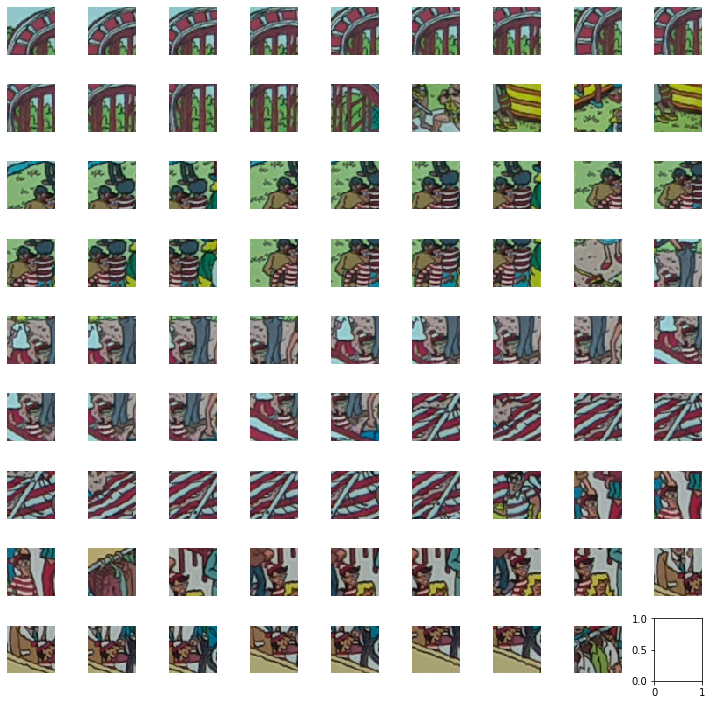

In [35]:
show_images(val_imgs[indices])